=== 【処理前】definition_ja 文字数統計 ===
count    18223.000000
mean        33.460791
std         43.868453
min          0.000000
25%          0.000000
50%         22.000000
75%         47.000000
max        603.000000
Name: len_original, dtype: float64


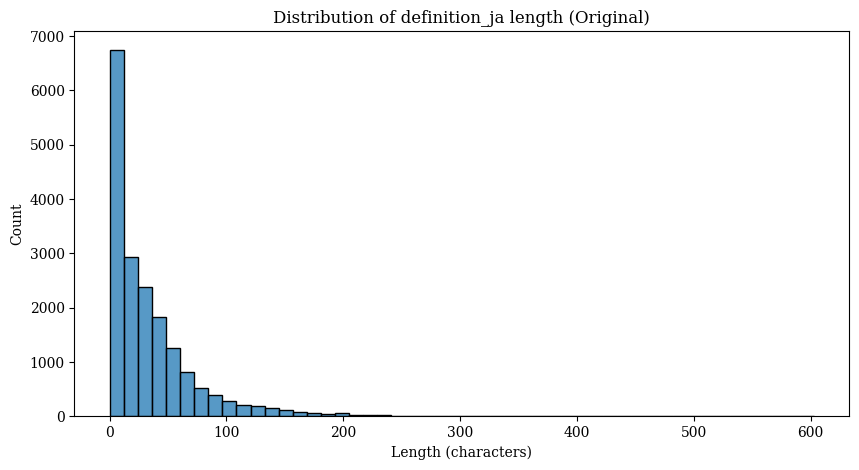

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. データの読み込み
# ==========================================
# 実際のマスタファイルパスに合わせて変更してください
input_csv = "../data/HPO_depth_ge3.csv"  # 例
df = pd.read_csv(input_csv)

# definition_ja カラムが存在することを確認（なければスキップ）
if 'definition_ja' not in df.columns:
    raise ValueError("CSVに 'definition_ja' カラムが見つかりません。")

# 欠損値（NaN）を空文字に置換して扱いやすくする
df['definition_ja'] = df['definition_ja'].fillna("").astype(str)

# ==========================================
# 2. 統計情報の確認（処理前）
# ==========================================
# 文字数を計算
df['len_original'] = df['definition_ja'].str.len()

print("=== 【処理前】definition_ja 文字数統計 ===")
print(df['len_original'].describe())

# (オプション) ヒストグラムで分布を可視化
plt.figure(figsize=(10, 5))
sns.histplot(df['len_original'], bins=50, kde=False)
plt.title("Distribution of definition_ja length (Original)")
plt.xlabel("Length (characters)")
plt.ylabel("Count")
plt.show()

In [18]:

def truncate_to_first_period(text: str) -> str:
    """
    文字列を受け取り、最初の「。」（句点）までを返す。
    - 「。」が含まれる場合: 最初の「。」までを返す（「。」を含む）
    - 「。」が含まれない場合:
        - 文字列が長すぎる場合（例: 100文字以上）は強制的にカットする処理を入れても良いが、
          ここでは「そのまま返す」または「末尾まで」とする。
    """
    if not text:
        return ""
    
    # 最初の「。」の位置を探す
    idx = text.find("。")
    
    if idx != -1:
        # 見つかったらそこまで（+1で句点を含める）
        text = text[:idx+1]
        if len(text) > 100:
            return text[:100]
        else:
            return text
    else:
        # 句点がない場合
        # そのまま返すか、あまりに長い場合は別途制限する
        # 今回は「文構造が崩れるのを防ぐためそのまま」とするが、
        # 強制カットしたい場合は return text[:50] などにする
        if len(text) > 100:
            return text[:100]
        return text

# 適用して新しいカラムを作る
df['definition_ja_short'] = df['definition_ja'].apply(truncate_to_first_period)

# ==========================================
# 4. 統計情報の確認（処理後）と効果測定
# ==========================================
df['len_short'] = df['definition_ja_short'].str.len()

print("\n=== 【処理後】definition_ja_short 文字数統計 ===")
print(df['len_short'].describe())

# 削減率の計算
total_chars_original = df['len_original'].sum()
total_chars_short = df['len_short'].sum()
reduction_rate = (1 - total_chars_short / total_chars_original) * 100

print(f"\n=== 削減効果 ===")
print(f"総文字数: {total_chars_original:,} -> {total_chars_short:,}")
print(f"削減率: {reduction_rate:.1f}%")

# 長いまま残ってしまったものの確認（句点がなかったものなど）
long_remainders = df[df['len_short'] > 100][['HPO_ID', 'definition_ja_short']]
if not long_remainders.empty:
    print(f"\n注意: 処理後も100文字を超えている行が {len(long_remainders)} 件あります（句点がなかった可能性）。")
    print(long_remainders.head())

# ==========================================
# 5. 保存（必要であれば）
# ==========================================
df.to_csv("../data/hpo_master_with_def_short.csv", index=False)


=== 【処理後】definition_ja_short 文字数統計 ===
count    18223.000000
mean        23.984745
std         23.444671
min          0.000000
25%          0.000000
50%         20.000000
75%         39.000000
max        100.000000
Name: len_short, dtype: float64

=== 削減効果 ===
総文字数: 609,756 -> 437,074
削減率: 28.3%


In [13]:
print(df.head())

       HPO_ID                                           name_en  jp_final  \
0  HP:0000003                      Multicystic kidney dysplasia   多嚢胞腎異形成   
1  HP:0000008  Abnormal morphology of female internal genitalia   女性内性器異常   
2  HP:0000009             Functional abnormality of the bladder    膀胱機能異常   
3  HP:0000010                Recurrent urinary tract infections  反復性尿路感染症   
4  HP:0000011                                Neurogenic bladder    神経因性膀胱   

   category       sub_category  depth  self_reportable                parents  \
0   symptom  symptom_candidate    7.0                0             HP:0000107   
1   symptom  symptom_candidate    5.0                0  HP:0000812|HP:0010460   
2   symptom  symptom_candidate    5.0                0             HP:0000014   
3  lab_test     lab_or_imaging    4.0                0  HP:0002719|HP:0011277   
4   symptom  symptom_candidate    6.0                1             HP:0000009   

                                            childr

In [20]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
import os
os.environ["HTTP_PROXY"] = "http://proxy.l2.med.tohoku.ac.jp:8080"
os.environ["HTTPS_PROXY"] = "http://proxy.l2.med.tohoku.ac.jp:8080"
model_name = "sociocom/MedTXTNER"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForTokenClassification.from_pretrained(model_name)

print(model.config.id2label)


{0: 'O', 1: 'B-d_', 2: 'I-d_', 3: 'B-d_positive', 4: 'I-d_positive', 5: 'B-d_suspicious', 6: 'I-d_suspicious', 7: 'B-d_negative', 8: 'I-d_negative', 9: 'B-d_general', 10: 'I-d_general', 11: 'B-a_', 12: 'I-a_', 13: 'B-f_', 14: 'I-f_', 15: 'B-c_', 16: 'I-c_', 17: 'B-d_other', 18: 'I-d_other', 19: 'B-timex3_', 20: 'I-timex3_', 21: 'B-timex3_date', 22: 'I-timex3_date', 23: 'B-timex3_time', 24: 'I-timex3_time', 25: 'B-timex3_duration', 26: 'I-timex3_duration', 27: 'B-timex3_set', 28: 'I-timex3_set', 29: 'B-timex3_age', 30: 'I-timex3_age', 31: 'B-timex3_med', 32: 'I-timex3_med', 33: 'B-timex3_misc', 34: 'I-timex3_misc', 35: 'B-timex3_CC', 36: 'I-timex3_CC', 37: 'B-t-test_', 38: 'I-t-test_', 39: 'B-t-test_executed', 40: 'I-t-test_executed', 41: 'B-t-test_negated', 42: 'I-t-test_negated', 43: 'B-t-test_scheduled', 44: 'I-t-test_scheduled', 45: 'B-t-test_other', 46: 'I-t-test_other', 47: 'B-t-key_', 48: 'I-t-key_', 49: 'B-t-key_scheduled', 50: 'I-t-key_scheduled', 51: 'B-t-val_', 52: 'I-t-val_'

In [24]:
# SFT JSONL の token 長をざっと見る
from transformers import AutoTokenizer
import json

tok = AutoTokenizer.from_pretrained("EQUES/MedLLama3-JP-v2")

lens = []
with open("../data/manbyo_doctor_hpo_sft.jsonl") as f:
    for i, line in enumerate(f):
        if i >= 2000: break
        ex = json.loads(line)
        full = tok.apply_chat_template(
            ex["messages"] + [{"role":"assistant","content":ex["output"]}],
            tokenize=True
        )
        lens.append(len(full))

print("max:", max(lens))
print("p95:", sorted(lens)[int(len(lens)*0.95)])


max: 422
p95: 375


In [23]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import json
from pathlib import Path

paths = [
    Path("../data/naist_patient_hpo_sft.jsonl"),
    Path("../data/manbyo_doctor_hpo_sft.jsonl"),
]

def check(path: Path, max_show=30):
    bad = 0
    total = 0
    print(f"== checking: {path}")
    with path.open("r", encoding="utf-8") as f:
        for ln, line in enumerate(f, start=1):
            line = line.strip()
            if not line:
                continue
            total += 1
            try:
                ex = json.loads(line)
            except Exception as e:
                bad += 1
                if bad <= max_show:
                    print(f"[BAD JSON] {path.name}:{ln} err={e} head={line[:200]}")
                continue

            if not isinstance(ex, dict):
                bad += 1
                if bad <= max_show:
                    print(f"[BAD TYPE] {path.name}:{ln} type={type(ex)} head={line[:200]}")
                continue

            if "messages" not in ex or "output" not in ex:
                bad += 1
                if bad <= max_show:
                    print(f"[MISSING KEY] {path.name}:{ln} keys={list(ex.keys())[:30]} head={line[:200]}")
                continue

            if not isinstance(ex["messages"], list):
                bad += 1
                if bad <= max_show:
                    print(f"[BAD messages TYPE] {path.name}:{ln} type={type(ex['messages'])}")
                continue

    print(f"== done: total={total} bad={bad} bad_rate={(bad/total if total else 0):.4f}\n")

for p in paths:
    check(p)


== checking: ../data/naist_patient_hpo_sft.jsonl
== done: total=6264 bad=0 bad_rate=0.0000

== checking: ../data/manbyo_doctor_hpo_sft.jsonl
== done: total=22252 bad=0 bad_rate=0.0000



In [ ]:
sh走らせたときの20251214_2200に関して
eques_baseとeques_qloraの生成結果doctor,patient双方の生成結果でassistantが含まれているのと，最初の一項だけ採用するのが働いてない気がします
なんでですか
またvllm_pipeline_2で生成表現の後処理ちゃんと実装できてますよね
またこれらの生成結果をきれいにした上でこれらのみ後処理にかけembeddingした上ですその後のプロセスは前回失敗してるので続きからお願いします
shをください